**INstalling required libraries**

In [ ]:
!pip install -U transformers

Transformer is a very huge library we were facing so many issues so we had to verify everything before proceeding further

In [ ]:
import transformers
print(transformers.__file__)

/usr/local/lib/python3.11/dist-packages/transformers/__init__.py


In [ ]:
!pip install datasets

In [ ]:
#installing required libraries
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


**TRAINING AND TESTING DISTILBERT MODEL**

In [ ]:
# processing function
def preprocess_function(examples):
    if "content" in examples:
        return tokenizer(examples['content'], truncation=True, padding=True)
    else:
        return tokenizer(examples['review'], truncation=True, padding=True)


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


In [ ]:
!pip install -U transformers datasets evaluate sentencepiece -q
#installing required libraries
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset, Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
import evaluate
from sklearn.metrics import classification_report

In [ ]:
#metrics calculation method
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [ ]:
# preprocessing steps to make the data available for training
accuracy_metric = evaluate.load("accuracy")
amazon_train = load_dataset('amazon_polarity', split='train[:10000]')
amazon_test_df = pd.read_csv("/content/test_5000.csv")
amazon_test = Dataset.from_pandas(amazon_test_df)
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
tokenized_train = amazon_train.map(preprocess_function, batched=True)
amazon_test = amazon_test.add_column("label", [0] * len(amazon_test))
tokenized_test = amazon_test.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# the below test data is to compare with aspect based
amazon_sen_test = load_dataset('amazon_polarity', split='test[:1000]')
tokenized_sentence_test = amazon_sen_test.map(preprocess_function, batched=True)
tokenized_sentence_test = tokenized_sentence_test.rename_column("label", "labels")
tokenized_sentence_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

**Training the distilBERT model**

In [ ]:
#training the distilbert model
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=42,
    logging_dir="./logs",
    logging_steps=500
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
preds = trainer.predict(tokenized_test)
pred_labels = np.argmax(preds.predictions, axis=1)
true_labels = tokenized_test["labels"]
final_test_df = amazon_test_df.copy()
#testing on 5000 dataset for aspect based
final_test_df["Predicted_Label"] = pred_labels
final_test_df["Predicted_Sentiment"] = final_test_df["Predicted_Label"].map({0: "Negative", 1: "Positive"})
final_test_df.to_csv("amazon_test_predictions.csv", index=False)
print("\nSaved final test set with predictions to 'amazon_test_predictions.csv'")


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-146a6c3d4ca2>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406700
1000,0.331000
1500,0.245700
2000,0.173600
2500,0.181700
3000,0.063500
3500,0.069800



Saved final test set with predictions to 'amazon_test_predictions.csv'


In [ ]:
#SAVING THE MODEL
save_directory = "./distilbert_sentiment_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./distilbert_sentiment_model


**Testing the DISTILBERT MODEL ON RECORDS TO COMPARE WITH SENTENCE BASED LSTM ALONG WITH CLASSIFICATION REPORT**

In [ ]:

from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import evaluate
accuracy_metric = evaluate.load("accuracy")
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
amazon_sen_test = load_dataset('amazon_polarity', split='test[:1000]')
tokenized_sentence_test = amazon_sen_test.map(preprocess_function, batched=True)
tokenized_sentence_test = tokenized_sentence_test.rename_column("label", "labels")
tokenized_sentence_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
preds2 = trainer.predict(tokenized_sentence_test)
labels = np.argmax(preds2.predictions, axis=1)
true_labels = tokenized_sentence_test["labels"]
accuracy = accuracy_metric.compute(predictions=labels, references=true_labels)
print(f"\nAccuracy on sentence-level test set: {accuracy['accuracy']:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, labels, target_names=["Negative", "Positive"]))
final_sentence_test_df = pd.DataFrame(amazon_sen_test)
final_sentence_test_df["Predicted_Sentiment"] = ["Positive" if pred == 1 else "Negative" for pred in labels]
final_sentence_test_df.to_csv("bert_predictions.csv", index=False)
print("\nSaved all predictions to 'bert_predictions.csv'")



Accuracy on sentence-level test set: 0.9130

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.91       498
    Positive       0.92      0.90      0.91       502

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000


Saved all predictions to 'bert_predictions.csv'


In [ ]:
# A GLIMPSE OF HOW THE OUTPUT FROM BERT LOOKS LIKE
final_sentence_test_df["True"] = final_sentence_test_df["label"].map({0: "Negative", 1: "Positive"})
final_sentence_test_df.to_csv("bert_predictions.csv", index=False)
final_sentence_test_df

,label,title,content,Predicted_Sentiment,True
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Positive,Positive
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,Positive,Positive
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Negative,Negative
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,Positive,Positive
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Positive,Positive
...,...,...,...,...,...
995,0,Borinmg & dumb,A waste of time.Glory for old time movies that...,Negative,Negative
996,1,Best film of the year,"One of the best films ever made, Gods and Mons...",Positive,Positive
997,1,See this movie just for Ian McKellen's perform...,"""Gods and Monsters"" is a superb movie about th...",Positive,Positive
998,1,best screenplays have more stability,One of the few recent films that I anticipated...,Positive,Positive


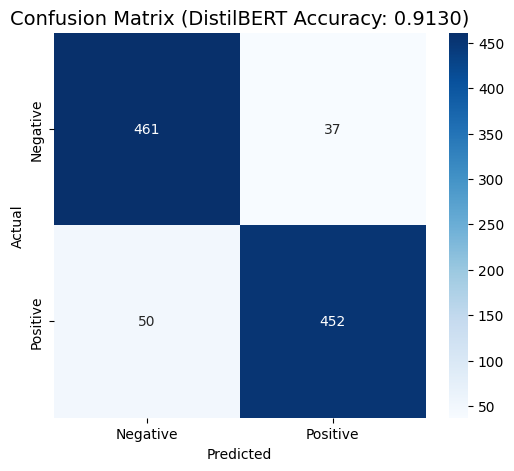

In [ ]:
# VISUALIZATION USING CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cf = confusion_matrix(true_labels, labels)
label_names = ["Negative", "Positive"]
plt.figure(figsize=(6, 5))
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.title(f'Confusion Matrix (DistilBERT Accuracy: {accuracy["accuracy"]:.4f})', size=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**LSTM MODEL LOADING AND GETTING PREDICTD LABELS FOR TESTING DATASET**

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datasets import load_dataset
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer, DataCollatorWithPadding
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^0-9a-zA-Z]', ' ', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

vocab_size = 25500
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_token = ''
embedding_dim = 25

amazon_train = load_dataset('amazon_polarity', split='train[:10000]')
training_sentences = [preprocess_text(sentence) for sentence in amazon_train['content']]
original_testing_sentences = amazon_sen_test['content']
testing_sentences = [preprocess_text(sentence) for sentence in amazon_sen_test['content']]
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
train_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_labels = amazon_train['label']
test_labels = amazon_sen_test['label']
train_padded, test_padded = np.array(train_padded), np.array(test_padded)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
best_model = tf.keras.models.load_model('lstm_model.h5')
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {test_accuracy*100}%')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7872 - loss: 0.4525
Test Accuracy: 78.79999876022339%


In [ ]:
pred_probs = best_model.predict(test_padded)
predicted_classes = np.argmax(pred_probs, axis=1)
sentiment_labels = ['Negative', 'Positive']
predicted_sentiments = [sentiment_labels[i] for i in predicted_classes]
results_df = pd.DataFrame({
    'Sentence': original_testing_sentences,
    'Predicted_Label': predicted_classes,
    'Predicted_Sentiment': predicted_sentiments
})
print(results_df.head())
results_df.to_csv('lstm_predictions.csv', index=False)
print("\nSaved all predictions to 'lstm_predictions.csv'")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
                                            Sentence  Predicted_Label  \
0  My lovely Pat has one of the GREAT voices of h...                0   
1  Despite the fact that I have only played a sma...                0   
2  I bought this charger in Jul 2003 and it worke...                0   
3  Check out Maha Energy's website. Their Powerex...                0   
4  Reviewed quite a bit of the combo players and ...                0   

  Predicted_Sentiment  
0            Negative  
1            Negative  
2            Negative  
3            Negative  
4            Negative  

Saved all predictions to 'lstm_predictions.csv'


**COMPARISION OF SENTENCE LEVEL LSTM VS DISTILBERT**

In [ ]:
import pandas as pd
bert_df = pd.read_csv("bert_predictions.csv")
lstm_df = pd.read_csv("lstm_predictions.csv")
bert_df["content_norm"] = bert_df["content"].str.strip().str.lower()
lstm_df["sentence_norm"] = lstm_df["Sentence"].str.strip().str.lower()
merged_df = pd.merge(
    lstm_df,
    bert_df,
    left_on="sentence_norm",
    right_on="content_norm"
)
final_df = merged_df[["Sentence","True", "Predicted_Sentiment_y", "Predicted_Sentiment_x"]]
final_df = final_df.rename(columns={
    "Predicted_Sentiment_y": "BERT_Predicted_Sentiment",
    "Predicted_Sentiment_x": "LSTM_Predicted_Sentiment",
    "True": "Actual Label"
})
final_df.to_csv("bert_lstm_sentiment_comparison.csv", index=False)
print(" Saved to 'bert_lstm_sentiment_comparison.csv'")


 Saved to 'bert_lstm_sentiment_comparison.csv'


In [ ]:
final_df.head()

,Sentence,Actual Label,BERT_Predicted_Sentiment,LSTM_Predicted_Sentiment
0,My lovely Pat has one of the GREAT voices of h...,Positive,Positive,Negative
1,Despite the fact that I have only played a sma...,Positive,Positive,Negative
2,I bought this charger in Jul 2003 and it worke...,Negative,Negative,Negative
3,Check out Maha Energy's website. Their Powerex...,Positive,Positive,Negative
4,Reviewed quite a bit of the combo players and ...,Positive,Positive,Negative
